# CS:GO Price Prediction - LightGBM Model

Training a LightGBM model to predict CS:GO weapon case prices using:
- **Lag features**: price_lag_1, price_lag_2, price_lag_3 (last 3 days of prices)
- **Player activity**: Average_Players (daily player count)
- **Tournament events**: has_tournament (S-Tier tournament indicator)
- **Item encoding**: item_encoded (50 weapon cases)

**Target**: Next day's price

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import time

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"LightGBM version: {lgb.__version__}")

LightGBM version: 4.6.0


In [2]:
# Load the dataset
df = pd.read_csv('csv-files/csgo_item_level_dataset.csv')

print(f"\nTotal records: {len(df):,}")
print(f"Features: {list(df.columns)}")
print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())
print(f"\nDataset statistics:")
print(df.describe())


Total records: 16,722
Features: ['item_encoded', 'price', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'Date', 'Average_Players', 'has_tournament']

Date range: 2024-10-07 to 2025-10-03

First 5 rows:
   item_encoded  price  price_lag_1  price_lag_2  price_lag_3        Date  \
0             0  0.209        0.224        0.219        0.207  2024-10-07   
1             0  0.203        0.209        0.224        0.219  2024-10-08   
2             0  0.194        0.203        0.209        0.224  2024-10-09   
3             0  0.204        0.194        0.203        0.209  2024-10-10   
4             0  0.212        0.204        0.194        0.203  2024-10-11   

   Average_Players  has_tournament  
0        1363872.0               1  
1        1400121.0               1  
2        1395317.0               1  
3        1346127.0               1  
4        1368886.0               1  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16722 entries, 0 to 16721
Data columns (total 8 

<br>

### Adjust features and target

In [3]:
"""
Prepare features and target
Features: item_encoded, lag features, player count, tournament flag
Target: price 
"""

feature_cols = ['item_encoded', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'Average_Players', 'has_tournament']
target_col = 'price'

X = df[feature_cols]
y = df[target_col]

<br>

### Split to train and test

In [4]:
# Sort by date first
df_sorted = df.sort_values('Date').reset_index(drop=True)

# Calculate split point (80% for training)
split_idx = int(len(df_sorted) * 0.8)

# Split chronologically
train_data = df_sorted.iloc[:split_idx]
test_data = df_sorted.iloc[split_idx:]

# Extract features and target
X_train = train_data[feature_cols].copy()
y_train = train_data[target_col]
X_test = test_data[feature_cols].copy()
y_test = test_data[target_col]

# Mark item_encoded as categorical for LightGBM
X_train['item_encoded'] = X_train['item_encoded'].astype('category')
X_test['item_encoded'] = X_test['item_encoded'].astype('category')

print(f"\n Training set:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   Date range: {train_data['Date'].min()} to {train_data['Date'].max()}")

print(f"\n Test set:")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")
print(f"   Date range: {test_data['Date'].min()} to {test_data['Date'].max()}")

print(f"\n Data types:")
print(X_train.dtypes)


 Training set:
   X_train: (13377, 6)
   y_train: (13377,)
   Date range: 2024-10-07 to 2025-07-28

 Test set:
   X_test: (3345, 6)
   y_test: (3345,)
   Date range: 2025-07-28 to 2025-10-03

 Data types:
item_encoded       category
price_lag_1         float64
price_lag_2         float64
price_lag_3         float64
Average_Players     float64
has_tournament        int64
dtype: object


<br>

#### Hyperparameter Tuning with GridSearchCV

Before training with fixed parameters, let's try to find the best parameters using GridSearchCV with TimeSeriesSplit

In [5]:
# GridSearchCV --> Find the best hyperparameters

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],           # Number of trees
    'max_depth': [4, 6, 8],                   # Tree depth
    'learning_rate': [0.05, 0.1, 0.2],        # Learning rate
    'subsample': [0.7, 0.8, 0.9],             # Subsample ratio
    'colsample_bytree': [0.7, 0.8, 0.9]       # Feature subsample ratio
}

# Create base model
base_model = lgb.LGBMRegressor(
    random_state=42,
    objective='regression',
    verbose=-1  # Suppress warnings
)

# TimeSeriesSplit for proper time series cross-validation
# This ensures we always train on past data and validate on future data
tscv = TimeSeriesSplit(n_splits=3)

# Create GridSearchCV object with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=base_model,          # LightGBM regressor
    param_grid=param_grid,         # use param_grid dictionary
    cv=tscv,                       # Time series cross-validation (not random)
    scoring='neg_mean_absolute_error',  # Minimize MAE, since this is a regression problem
    verbose=1,                     # Show progress
    n_jobs=-1                      # Use all CPU cores
)

print(f"\nParameter grid:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

# Calculate total combinations
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)

print(f"\nTotal combinations to test: {total_combinations}")
print(f"Starting GridSearchCV...\n")

# Fit GridSearchCV
grid_search.fit(X_train, y_train, categorical_feature=['item_encoded'])

print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nBest cross-validation score (MAE): ${-grid_search.best_score_:.4f}")

# Get the best model
model = grid_search.best_estimator_


Parameter grid:
   n_estimators: [50, 100, 150]
   max_depth: [4, 6, 8]
   learning_rate: [0.05, 0.1, 0.2]
   subsample: [0.7, 0.8, 0.9]
   colsample_bytree: [0.7, 0.8, 0.9]

Total combinations to test: 243
Starting GridSearchCV...

Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best parameters found:
   colsample_bytree: 0.8
   learning_rate: 0.05
   max_depth: 6
   n_estimators: 150
   subsample: 0.7

Best cross-validation score (MAE): $0.1106


<br>

### Model training metrics

In [6]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)


print(f"TRAINING SET:")
print(f"   MAE (Mean Absolute Error):  ${train_mae:.4f}")
print(f"   RMSE (Root Mean Squared):   ${train_rmse:.4f}")
print(f"   R² Score:                   {train_r2:.4f}\n")

print(f"TEST SET:")
print(f"   MAE (Mean Absolute Error):  ${test_mae:.4f}")
print(f"   RMSE (Root Mean Squared):   ${test_rmse:.4f}")
print(f"   R² Score:                   {test_r2:.4f}")

TRAINING SET:
   MAE (Mean Absolute Error):  $0.0315
   RMSE (Root Mean Squared):   $0.1135
   R² Score:                   0.9981

TEST SET:
   MAE (Mean Absolute Error):  $0.0627
   RMSE (Root Mean Squared):   $0.1908
   R² Score:                   0.9964


<br>

### Feature Importance

Feature Importance (Gain-based):
        feature  importance
    price_lag_1        1701
Average_Players        1030
    price_lag_3         603
    price_lag_2         595
   item_encoded         169
 has_tournament         117



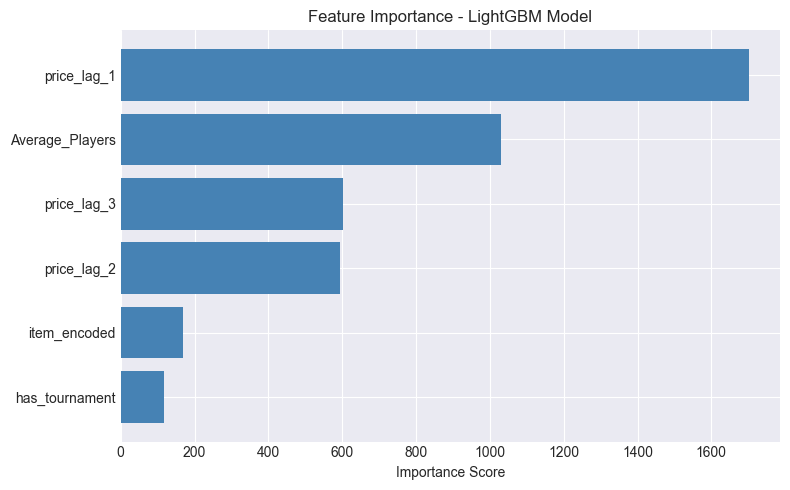

In [7]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Gain-based):")
print(feature_importance.to_string(index=False))
print()

# Visualize feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance - LightGBM Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<br>

#### Save the Model

In [8]:
# Save the trained model
model_filename = 'csgo_price_prediction_model_lightgbm.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved: {model_filename}")

Model saved: csgo_price_prediction_model_lightgbm.pkl


<br><br>

---

## Make Predictions

Purpose is the predict tomorrows price

####  What You Need to Provide (6 inputs):

```
TODAY is: October 4, 2025
YOU WANT: October 5, 2025 price

INPUTS YOU PROVIDE:
1. Item name               → "Dreams & Nightmares Case"
2. Today's price (Oct 4)   → $0.35  (this becomes price_lag_1)
3. Yesterday's price (Oct 3) → $0.34  (this becomes price_lag_2)
4. 2 days ago price (Oct 2)  → $0.33  (this becomes price_lag_3)
5. Avg players today         → 1,500,000
6. Has tournament today      → 0 (No) or 1 (Yes)

OUTPUT YOU GET:
- Predicted price for TOMORROW (Oct 5) → $0.349
```

<br>

In [9]:
# Load item mapping to get item names
with open('csv-files/item_mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)
    item_to_id = mapping['item_to_id']
    id_to_item = mapping['id_to_item']


print(f"\nAvailable items ({len(item_to_id)}):")
print("\nFirst 10 items:")
for i, (item_name, item_id) in enumerate(sorted(item_to_id.items())[:10]):
    print(f"   {item_id:2d}: {item_name}")
print("   ...")
print("\nLast 5 items:")
for i, (item_name, item_id) in enumerate(sorted(item_to_id.items())[-5:]):
    print(f"   {item_id:2d}: {item_name}")


Available items (50):

First 10 items:
    0: 2020 RMR Challengers
    1: 2020 RMR Contenders
    2: 2020 RMR Legends
    3: Antwerp 2022 Challengers Autograph Capsule
    4: Antwerp 2022 Challengers Sticker Capsule
    5: Antwerp 2022 Contenders Sticker Capsule
    6: Antwerp 2022 Legends Sticker Capsule
    7: Austin 2025 Challengers Sticker Capsule
    8: Austin 2025 Contenders Sticker Capsule
    9: Austin 2025 Legends Sticker Capsule
   ...

Last 5 items:
   45: Shanghai 2024 Contenders Autograph Capsule
   46: Shanghai 2024 Legends Autograph Capsule
   47: Snakebite Case
   48: Spectrum 2 Case
   49: Spectrum Case


<br>

### Prediction

In [19]:
# Example: Custom prediction function
def predict_item_price(item_name, price_lag_1, price_lag_2, price_lag_3, 
                       avg_players=1500000, has_tournament=0):
    """
    Predict TOMORROW'S price for a specific CS:GO item.
    
    Parameters (What user provides):
    -----------
    item_name : str
        Name of the CS:GO weapon case
        Example: "Dreams & Nightmares Case"
    
    price_lag_1 : float
        TODAY'S price (e.g., Oct 4 if predicting Oct 5)
        Example: 0.35
    
    price_lag_2 : float
        YESTERDAY'S price (e.g., Oct 3 if predicting Oct 5)
        Example: 0.34
    
    price_lag_3 : float
        Price from 2 DAYS AGO (e.g., Oct 2 if predicting Oct 5)
        Example: 0.33
    
    avg_players : int
        Average players TODAY (default: 1,500,000)
        Example: 1500000
    
    has_tournament : int
        Is there a tournament TODAY? 0 = No, 1 = Yes (default: 0)
        Example: 0
    
    Returns:
    --------
    float : Predicted price for TOMORROW
    
    Example Usage:
    --------------
    # It's Oct 4, you want to predict Oct 5
    predicted = predict_item_price(
        item_name="Dreams & Nightmares Case",
        price_lag_1=0.35,  # Oct 4 (today)
        price_lag_2=0.34,  # Oct 3 (yesterday)
        price_lag_3=0.33,  # Oct 2 (2 days ago)
        avg_players=1500000,
        has_tournament=0
    )
    # Output: 0.349 (predicted price for Oct 5)
    """
    
    # Get item ID
    if item_name not in item_to_id:
        raise ValueError(f"Item '{item_name}' not found. Check spelling or see available items.")
    
    item_id = item_to_id[item_name]
    
    # Prepare features
    features = pd.DataFrame({
        'item_encoded': [item_id],
        'price_lag_1': [price_lag_1],
        'price_lag_2': [price_lag_2],
        'price_lag_3': [price_lag_3],
        'Average_Players': [avg_players],
        'has_tournament': [has_tournament]
    })
    
    # Convert item_encoded to category
    features['item_encoded'] = features['item_encoded'].astype('category')
    
    # Predict
    prediction = model.predict(features)[0]
    
    return prediction


item = "Glove Case"
today_price = 15.34    # TODAY  
yesterday_price = 15.43    # YESTERDAY  
two_days_ago_price = 14.95    # 2 DAYS AGO  
has_tournament = 1

predicted = predict_item_price(
    item_name=item,
    price_lag_1=today_price,  # Today
    price_lag_2=yesterday_price,  # Yesterday
    price_lag_3=two_days_ago_price,  # 2 days ago
    avg_players=160000,
    has_tournament=1
)

print(f"\n Item: {item}")

print(f"   Today price: ${today_price:.3f}")
print(f"   Yesterday price: ${yesterday_price:.3f}")
print(f"   2 days ago price: ${two_days_ago_price:.3f}")
print(f"   Players today: 1,500,000")
print(f"   Tournament today: {has_tournament}")
print(f"\n OUTPUT")
print(f"   Tomorrow's  predicted price: ${predicted:.3f}")
print(f"   Expected change: ${predicted - today_price:+.3f} ({((predicted/today_price)-1)*100:+.2f}%)")


 Item: Glove Case
   Today price: $15.340
   Yesterday price: $15.430
   2 days ago price: $14.950
   Players today: 1,500,000
   Tournament today: 1

 OUTPUT
   Tomorrow's  predicted price: $16.320
   Expected change: $+0.980 (+6.39%)
